# Newspaper Segmentation

Network backbone is a Resnet101

In [1]:
import os
import re
import sys
import cv2
import math
import json
import time
import random
import skimage

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Root directory of the project
ROOT_DIR = os.path.abspath("")
sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs") # Directory to save logs and trained model
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5") # Local path to trained weights file

if not os.path.exists(COCO_MODEL_PATH): # Download COCO trained weights
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class ShapesConfig(Config):
    NAME = "newspapers"
    GPU_COUNT = 1 # Train on 1 GPU and 8 images per GPU.
    IMAGES_PER_GPU = 8 # Batch size is 8 (GPUs * images/GPU).
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    MINI_MASK_SHAPE = (128,128)
    
    IMAGE_RESIZE_MODE = 'square' #square or pad64 or crop
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels to extract low resolution 
    TRAIN_ROIS_PER_IMAGE = 32
    
    STEPS_PER_EPOCH = 100  # Use a small epoch since the data is simple
    VALIDATION_STEPS = 5 # use small validation steps since the epoch is small
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=12):
    """Return a Matplotlib Axes"""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

* load_image()
* load_mask()
* image_reference()

In [4]:
class newspaperDataset(utils.Dataset):
    
    def load_data(self, dataset_dir, subset):
        """
        Load a subset of the newspaper dataset.
            
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """

        self.add_class("newspaper", 0, "article")
        self.add_class("newspaper", 1, "non-article")
        self.add_class("newspaper", 2, "title")

        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        filenames = list(annotations.keys())
        annotations = list(annotations.values())

        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            shapes = [r['shape_attributes'] for r in a['regions'].values()]
            classes = [r['region_attributes']['label'] for r in a['regions'].values()]

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "newspaper",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                shapes=shapes,
                classes=classes)
            
        return filenames

    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "newspaper":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        classes = info['classes']
        
        mask = np.zeros([info["height"], info["width"], len(info["shapes"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["shapes"]):
            if p['name'] == 'polygon':
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1
                
            if p['name'] == 'rectangle':
                start = (int(p['ymin']),int(p['xmin']))
                extent = (int(p['ymax']),int(p['xmax']))
                
                rr, cc = skimage.draw.rectangle(start=start, extent=extent, shape=mask.shape)
                mask[rr, cc, i] = 1
                
        class_ids = np.array([self.class_names.index(s) for s in classes])
        
        return mask, class_ids
    
    def image_reference(self, image_id):

        info = self.image_info[image_id]
        if info["source"] == "newspaper":
            return info["newspaper"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [5]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_train = newspaperDataset()
data_names = dataset_train.load_data(data_DIR, "train")
dataset_train.prepare()

In [6]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_val = newspaperDataset()
data_names_val = dataset_val.load_data(data_DIR, "val")
dataset_val.prepare()

In [7]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_test = newspaperDataset()
data_names_test = dataset_test.load_data(data_DIR, "test")
dataset_test.prepare()

In [8]:
dataset_test.image_ids

array([0, 1, 2, 3, 4, 5, 6, 7])

### Useful functions

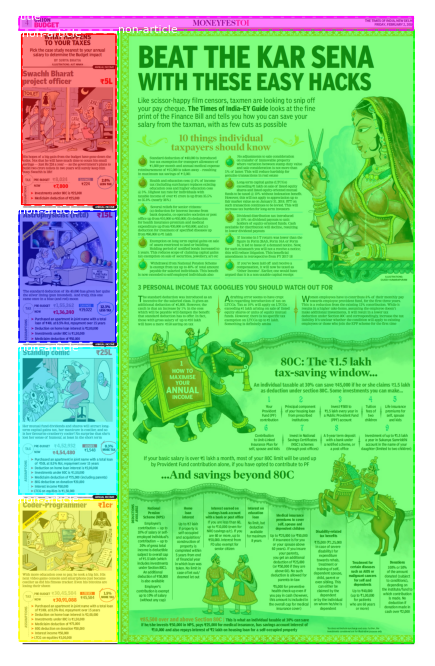

In [9]:
for ids in dataset_test.image_ids[2:3]:
    mask, class_ids = dataset_test.load_mask(ids)
    bbox = utils.extract_bboxes(mask)
    
    image_path = data_DIR+'/test/'+data_names_test[ids]
    image = skimage.io.imread(image_path)

#     visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    visualize.display_instances(image, bbox, mask, class_ids, dataset_test.class_names,figsize=(12, 12))
    
#     image, window, scale, padding, _ = utils.resize_image(
#         image, 
#         min_dim=config.IMAGE_MIN_DIM, 
#         max_dim=config.IMAGE_MAX_DIM,
#         mode='square')
#     mask = utils.resize_mask(mask, scale, padding)
    
#     log("image", image)
#     log("mask", mask)
    
#     bbox = utils.extract_bboxes(mask)
#     visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,figsize=(8, 8))

In [10]:
class_ids

array([2, 2, 2, 2, 2, 3])

## Create Model

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [12]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [13]:
# # Train the head branches
# # Passing layers="heads" freezes all layers except the head
# # layers. You can also pass a regular expression to select
# # which layers to train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=3, 
#             layers='heads')

In [14]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=4, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: C:\Users\senba\Desktop\Gustovalley\Projects-University\Ph.D Projects\Programming\Modelling\logs\newspapers20210831T1330\mask_rcnn_newspapers_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)

C:\Users\senba\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\senba\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_clas

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 8.0000 - loss: 3.5081 - rpn_class_loss: 0.1444 - rpn_bbox_loss: 1.5594 - mrcnn_class_loss: 0.5673 - mrcnn_bbox_loss: 0.6361 - mrcnn_mask_loss: 0.6009 

C:\Users\senba\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100/100 [==============================] - 2970s 29s/step - batch: 49.5000 - size: 8.0000 - loss: 3.5081 - rpn_class_loss: 0.1444 - rpn_bbox_loss: 1.5594 - mrcnn_class_loss: 0.5673 - mrcnn_bbox_loss: 0.6361 - mrcnn_mask_loss: 0.6009 - val_loss: 3.7702 - val_rpn_class_loss: 0.1487 - val_rpn_bbox_loss: 2.0966 - val_mrcnn_class_loss: 0.5361 - val_mrcnn_bbox_loss: 0.4907 - val_mrcnn_mask_loss: 0.4980
Epoch 2/4
100/100 [==============================] - 8149s 82s/step - batch: 49.5000 - size: 8.0000 - loss: 2.0988 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 0.8768 - mrcnn_class_loss: 0.3391 - mrcnn_bbox_loss: 0.4044 - mrcnn_mask_loss: 0.3959 - val_loss: 3.9152 - val_rpn_class_loss: 0.1425 - val_rpn_bbox_loss: 2.3714 - val_mrcnn_class_loss: 0.5063 - val_mrcnn_bbox_loss: 0.4801 - val_mrcnn_mask_loss: 0.4149
Epoch 3/4
100/100 [==============================] - 8095s 81s/step - batch: 49.5000 - size: 8.0000 - loss: 1.6343 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.6867 - mrcnn_class_loss: 0.2542

In [15]:
# Save weights 4/11
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [16]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights from  C:\Users\senba\Desktop\Gustovalley\Projects-University\Ph.D Projects\Programming\Modelling\logs\newspapers20210831T1330\mask_rcnn_newspapers_0004.h5
Re-starting from epoch 4


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 2567.00000  float64
gt_class_id              shape: (9,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (9, 4)                min:    2.00000  max:  125.00000  int32
gt_mask                  shape: (128, 128, 9)         min:    0.00000  max:    1.00000  bool


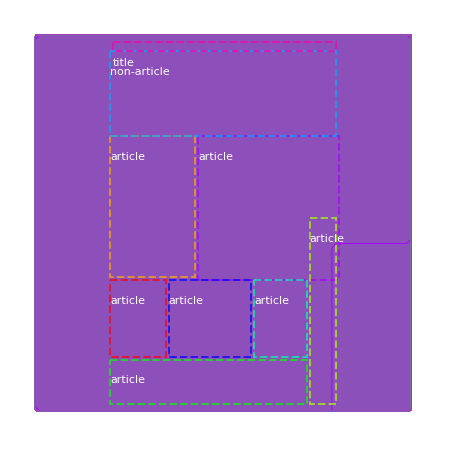

In [17]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
image_id = 6
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id) #use_mini_mask=False

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

In [23]:
cv2.imshow("out",original_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


C:\Users\senba\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


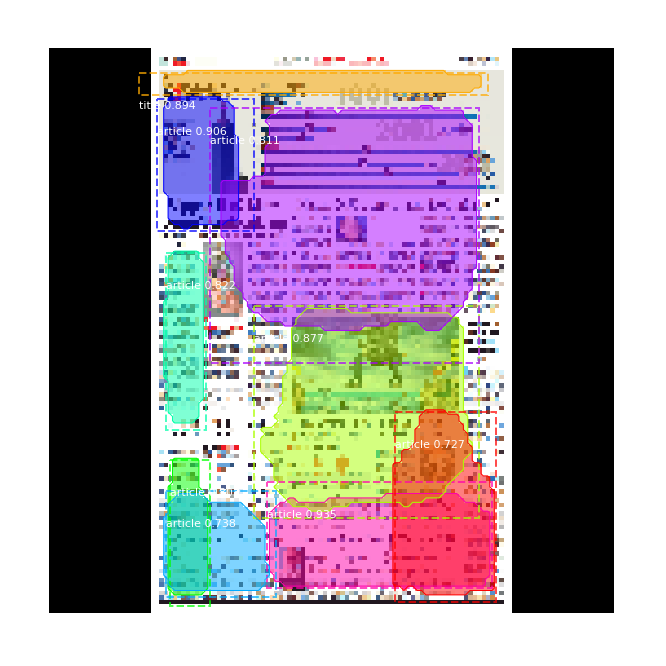

In [19]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

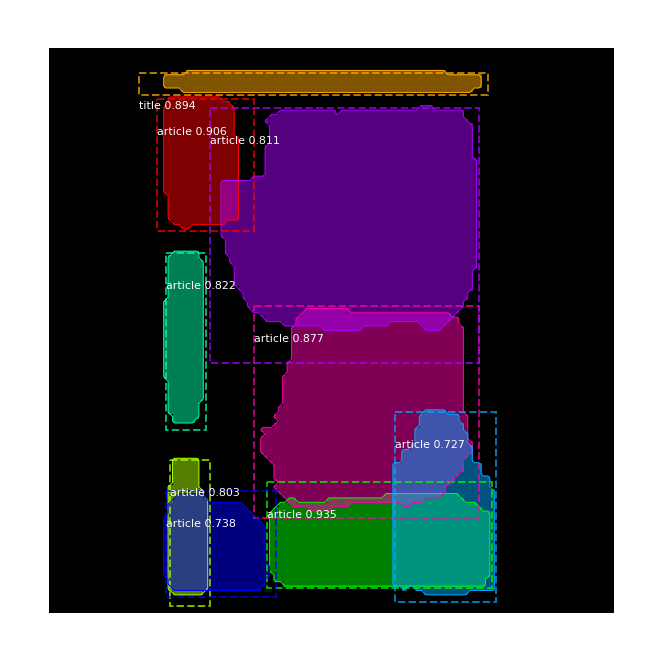

In [22]:
visualize.display_instances(mask1, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

In [ ]:
r['rois']

In [21]:
mask1 = np.ones(original_image.shape, dtype="uint8") * 0

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
import tensorflow
tensorflow.__version__